Draw FC from SGM at different freqs and SGM params

## Import some pkgs

In [1]:
import sys
sys.path.append("./mypkg")

import scipy
import itertools

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import trange
from scipy.io import loadmat
from functools import partial
from easydict import EasyDict as edict


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# my own fns
from brain import Brain
from FC_utils import build_fc_freq_m
from constants import RES_ROOT, DATA_ROOT, FIG_ROOT
from utils.misc import load_pkl, save_pkl
from utils.reparam import theta_raw_2out, logistic_np, logistic_torch

plt.style.use(FIG_ROOT/"base.mplstyle")

### Some fns

In [4]:
_minmax_vec = lambda x: (x-np.min(x))/(np.max(x)-np.min(x))

<function __main__.<lambda>(x)>

In [5]:
# transfer vec to a sym mat
def vec_2mat(vec):
    mat = np.zeros((68, 68))
    mat[np.triu_indices(68, k = 1)] = vec
    mat = mat + mat.T
    return mat

### Some parameters

In [6]:
# SC
ind_conn_xr = xr.open_dataarray(DATA_ROOT/'individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values

# PSD
ind_psd_xr = xr.open_dataarray(DATA_ROOT/'individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values
fvec = ind_psd_xr["frequencies"].values;

In [7]:
_paras = edict()
_paras.delta = [2, 3.5]
_paras.theta = [4, 7]
_paras.alpha = [8, 12]
_paras.beta_l = [13, 20]

In [13]:
paras = edict()

paras.nepoch = 100
paras.fs = 600
paras.par_low = np.asarray([0.005, 5, 0.1])
paras.par_high = np.asarray([0.03, 20, 1])
paras.names = ["tauC", "speed", "alpha"]


paras.allbds = ["delta", "theta", "alpha", "beta_l"]
paras.add_v = 0.01


### Load the data

In [9]:
brain = Brain.Brain()
brain.add_connectome(DATA_ROOT) # grabs distance matrix
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

bands = ["delta", "theta", "alpha", "beta_l"]

['delta', 'theta', 'alpha', 'beta_l']

In [ ]:
# get the posterior sps
par_low = np.asarray([0.005, 5, 0.1])
par_high = np.asarray([0.03, 20, 1])
prior_bds = np.array([par_low, par_high]).T;
_theta_raw_2out = partial(theta_raw_2out, map_fn=partial(logistic_np, k=1), prior_bds=prior_bds);

post_spss = []
ab_res_fils = list(RES_ROOT.glob(f"rawfc2allbd_SBIxANNALLBD_"
                                 f"{'-'.join(paras.allbds)}_"
                                 f"ep{paras.nepoch}_"
                                 f"num1000_densitynsf_MR3_noise_sd120_"
                                 f"addv{paras.add_v*100:.0f}"
                                 f"/ind*.pkl"))
ab_res_fils = sorted(ab_res_fils, key=lambda p: int(p.stem.split("ind")[-1]));
for fil in ab_res_fils:
    res = load_pkl(fil, verbose=False);
    sps = res.sample((1000, ));
    post_sps = _theta_raw_2out(sps.numpy());
    post_spss.append(post_sps)

In [12]:
est_params = np.array(post_spss).mean(axis=(0, 1))

base_sgmparams = edict({ "tauC":est_params[0], 
                        "speed":est_params[1], 
                        "alpha":est_params[2]})

{'tauC': 0.005013024009366304,
 'speed': 19.993560992007453,
 'alpha': 0.7468937225688176}

## Get plots

In [35]:
cur_params = 'alpha'
uplim = paras.par_high[paras.names.index(cur_params)]
lowlim = paras.par_low[paras.names.index(cur_params)]
midpt = (uplim+lowlim)/2

sgmparams_ub = base_sgmparams.copy()
sgmparams_ub[cur_params] = uplim
sgmparams_lb = base_sgmparams.copy()
sgmparams_lb[cur_params] = lowlim
sgmparams_mid = base_sgmparams.copy()
sgmparams_mid[cur_params] = midpt

sgmparamss = edict()
sgmparamss.ub = sgmparams_ub
sgmparamss.lb = sgmparams_lb
sgmparamss.mid = sgmparams_mid

In [38]:
key = "ub"
fcs = []
for band in bands:
    freqrange =  np.linspace(_paras[band][0], _paras[band][1], 5)
    fc = build_fc_freq_m(brain, sgmparamss[key], freqrange)
    fcs.append(fc[:68, :68])
    
for bandix in range(len(bands)):
    sns.heatmap(fcs[bandix], square=True, cbar=False, cmap="viridis", vmin=0.1, vmax=0.3)
    
    plt.yticks([])
    plt.xticks([]);
    plt.savefig(FIG_ROOT/f"SGMsimu_FC_{cur_params}_{bands[bandix]}_{key}.jpg")
    plt.close()

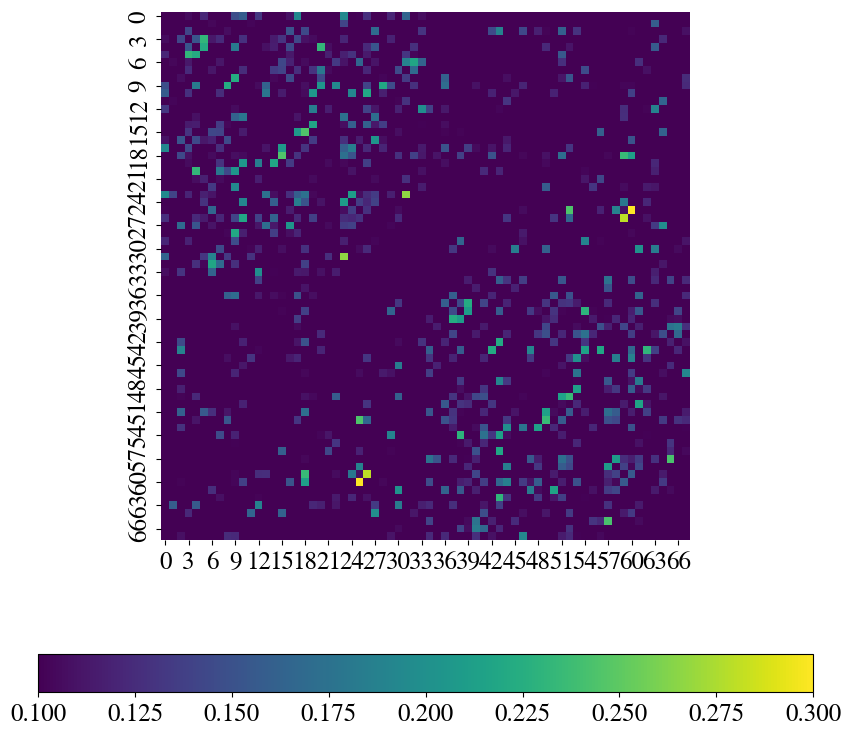

In [29]:
# get color bar
ax = sns.heatmap(fcs[bandix], square=True, cbar=False, 
                 cmap="viridis", vmin=0.1, vmax=0.3)

cbar = plt.colorbar(ax.collections[0], orientation='horizontal')
plt.savefig(FIG_ROOT/f"SGMsimu_FC_colorbar.jpg")